In [1]:
#Liberias necesarias:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
#Carga de datos:
datos = pd.read_excel("E-Commerce_train.xlsx")
datos = datos.drop(["ID"], axis=1)
columns_spanish = ["Bloque_de_Almacen","Modo_de_Envio","Llamadas_de_atecion_cliente","Valoracion_de_clientes","Coste_del_producto","Compras_Anteriores","Importancia_del_producto","Genero","Descuento","Peso_en_gramos","A_Tiempo"]
datos.columns = columns_spanish
datos.head(3)

,Bloque_de_Almacen,Modo_de_Envio,Llamadas_de_atecion_cliente,Valoracion_de_clientes,Coste_del_producto,Compras_Anteriores,Importancia_del_producto,Genero,Descuento,Peso_en_gramos,A_Tiempo
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1


In [7]:
# Separamos la ultima columna para que sea variable dependiente o salida.
datos_y = datos[datos.columns[-1]]
datos_y.head()

0    1
1    1
2    1
3    1
4    1
Name: A_Tiempo, dtype: int64

In [3]:
#Las columnas categoricas las transformamos en ordinales:
datos["Bloque_de_Almacen"].replace(["A", "B", "C", "D", "F"], [ 1, 2, 3, 4, 5], inplace = True)
datos["Modo_de_Envio"].replace(["Ship", "Flight", "Road"], [10, 20, 30,], inplace = True)
datos["Importancia_del_producto"].replace(["low", "medium", "high"], [10, 20, 30,], inplace = True)
datos["Genero"].replace(["F", "M"], [1, 0 ], inplace = True)

In [4]:
#Se seleciona del data frame original, las variables independientes:
datos_x = datos[["Bloque_de_Almacen","Modo_de_Envio","Llamadas_de_atecion_cliente","Valoracion_de_clientes","Coste_del_producto","Compras_Anteriores","Importancia_del_producto","Genero","Descuento","Peso_en_gramos"]]

In [5]:
#Se estandariza la data:
escalador = StandardScaler()
datos_x = escalador.fit_transform(datos_x)
print(datos_x.shape)

(8999, 10)


In [8]:
#Se separan los datos, en datos de entrenamiento y testeo
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datos_x, datos_y, test_size = 0.2, random_state = 0)

In [9]:
print("X Train: {}, X Test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X Train: (7199, 10), X Test: (1800, 10), y_train: (7199,), y_test: (1800,)


In [10]:
n_entradas = X_train.shape[1]
n_entradas

10

In [13]:
t_X_train = torch.Tensor(X_train).to("cpu") 

In [14]:
t_X_train = torch.Tensor(X_train).to("cpu") 
t_X_test = torch.Tensor(X_test).to("cpu")
t_y_train = torch.Tensor(y_train.values).to("cpu")
t_y_test = torch.Tensor(y_test.values).to("cpu")
t_y_train = t_y_train[:,None]
t_y_test = t_y_test[:, None]

In [15]:
test = TensorDataset(t_X_test, t_y_test)
print(test[0])

(tensor([-1.5651, -0.6354, -0.8913,  0.0035,  0.8789, -0.9866, -0.9447, -1.0090,
        -0.6953,  0.9808]), tensor([0.]))


In [16]:
t_y_train

tensor([[0.],
        [1.],
        [1.],
        ...,
        [1.],
        [0.],
        [1.]])

In [17]:
#Modelo de red neuronal totamente conectada de 3 capas:
#El modelo de He (Net_He), significa que los parametros(w) no se inicia con valores cercanos a 0,
#sino en cambio en relación a la cantidad de neuronas (n) en su respectiva capa: sqrt(n/2).

#Se crea la case Net_He que hereda de la clase torch nn.Module:
class Net_He(nn.Module):
    
    def __init__(self, n_entradas):
        #Se hereda se la clase nn.Module, la clase Net_He:
        super(Net_He, self).__init__()
        #Estrutura de la red neuronal:
        self.linear1 = nn.Linear(n_entradas, 8)
        self.linear2 = nn.Linear(8, 3)
        self.linear3 = nn.Linear(3, 1)
    
    def forward(self, inputs):
        #Se seleciona las funciones de activacion no lineal para cada una de las salidas de cada capa de la red neuronal:
        pred_1 = torch.relu(input=self.linear1(inputs))
        pred_2 = torch.relu(input=self.linear2(pred_1))
        pred_f = torch.sigmoid(input=self.linear3(pred_2))

        #Nos retorna un  valor que va de  0 a 1, el cual es la probabilidad de que los valores de las variables
        # independientes, de un ejemplo, pertenezcan a la clase 1.  
        return pred_f

In [23]:
# Loop de Entrenamiento.

#Se define los hiperparametros

%time
lr = 0.001  #Learning rate
epochs = 1200   #Cantidad de  Epocas

estatus_print = 100 # Cada cuantas epocas mostrar el valor de la precisión y el tiempo transcurrido:

#Se instancia el modelo Net_he en model, con la variable de 
#n_entradas(cantidas de columnas de los datos de entrenamiento)

model = Net_He(n_entradas=n_entradas)
#Se devine que la función se contos sera Binary Cross Entropy (por solo tener 2 clase_: 1 o 0) 
loss_fn = nn.BCELoss()
#Se selecciona el optimizador a usar, en este caso Adam:
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

print("Arquitectura del modelo: {}".format(model))

#Se guarda en un dataframe los valores que toman: epoch/Loss/Accuracy
historico = pd.DataFrame()

print("Entranando el modelo")

#Se entrena el modelo por epoch:
for epoch in range(1, epochs+1):
    #se instancia el modelo (red neruronal)
    y_pred= model(t_X_train)
    #se calcula la perdida
    loss = loss_fn(input=y_pred, target=t_y_train)
    #Se guarda los resultados de las ecuaciones diferenciales de cada tensor, cuando se realiza 
    #la retropropagación
    loss.backward()
    #Los gradientes toman el valor de 0 en cada ciclo de entrenamiento: 
    optimizer.step()
    optimizer.zero_grad()
    
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(loss.item(), 4)}")
    
    #Para calcular el acuaracy del modelo, segun las cantiada de iteraciones que se realicen:
    with torch.no_grad():
        y_pred = model(t_X_test)
        y_pred_class = y_pred.round()
        correct = (y_pred_class == t_y_test).sum()
        accuracy = 100 * correct / float(len(t_y_test))
        if epoch % estatus_print == 0:
            print("Accuracy: {}".format(accuracy.item()))
    
    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(loss.item(), 4),
        'Accuracy': round(accuracy.item(), 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)

print("Accuracy final: {}".format(round(accuracy.item(), 4)))

CPU times: total: 0 ns
Wall time: 0 ns
Arquitectura del modelo: Net_He(
  (linear1): Linear(in_features=10, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=3, bias=True)
  (linear3): Linear(in_features=3, out_features=1, bias=True)
)
Entranando el modelo

Epoch 100 	 Loss: 0.6531
Accuracy: 60.55555725097656

Epoch 200 	 Loss: 0.5591
Accuracy: 66.94444274902344

Epoch 300 	 Loss: 0.5134
Accuracy: 68.88888549804688

Epoch 400 	 Loss: 0.4975
Accuracy: 68.38888549804688

Epoch 500 	 Loss: 0.491
Accuracy: 68.38888549804688

Epoch 600 	 Loss: 0.4865
Accuracy: 68.11111450195312

Epoch 700 	 Loss: 0.4824
Accuracy: 68.27777862548828

Epoch 800 	 Loss: 0.4793
Accuracy: 68.05555725097656

Epoch 900 	 Loss: 0.4766
Accuracy: 67.72222137451172

Epoch 1000 	 Loss: 0.4741
Accuracy: 67.27777862548828

Epoch 1100 	 Loss: 0.4722
Accuracy: 67.38888549804688

Epoch 1200 	 Loss: 0.4706
Accuracy: 67.61111450195312
Accuracy final: 67.6111


### Como se observa se llega una precision del 67.6%

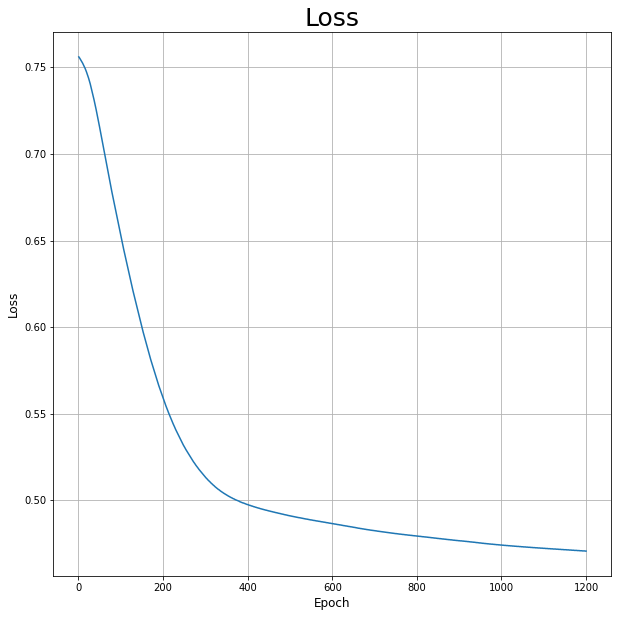

In [24]:
#Se gráfica el cambio en la perdida (Loss) por cada epoca:

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Loss'], label='Loss')
plt.title("Loss", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid()
plt.show()

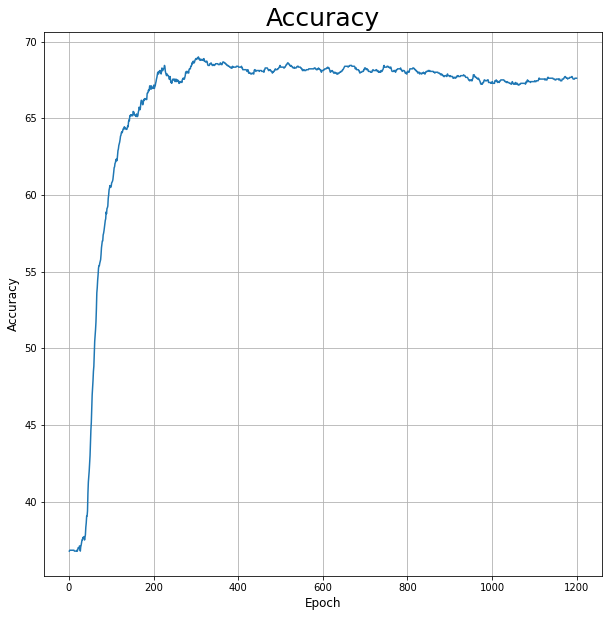

In [25]:
#Se gráfica la precision del modelo (Accuracy):

plt.figure(figsize=(10, 10))
plt.plot(historico['Epoch'], historico['Accuracy'], label='Accuracy')
plt.title("Accuracy", fontsize=25)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid()
plt.show()

## Probando con "E-Commerce_test.xlsx"

In [90]:
datos_test = pd.read_excel("E-Commerce_test.xlsx")
datos_test = datos_test.drop(["ID"], axis=1)
columns_spanish = ["Bloque_de_Almacen","Modo_de_Envio","Llamadas_de_atecion_cliente","Valoracion_de_clientes","Coste_del_producto","Compras_Anteriores","Importancia_del_producto","Genero","Descuento","Peso_en_gramos",]
datos_test.columns = columns_spanish
datos_test.head(3)

,Bloque_de_Almacen,Modo_de_Envio,Llamadas_de_atecion_cliente,Valoracion_de_clientes,Coste_del_producto,Compras_Anteriores,Importancia_del_producto,Genero,Descuento,Peso_en_gramos
0,F,Ship,5,1,189,2,medium,M,10,5248
1,D,Ship,5,3,150,2,high,F,9,4446
2,F,Ship,3,3,200,3,low,M,3,5739


In [91]:
datos_test["Bloque_de_Almacen"].replace(["A", "B", "C", "D", "F"], [ 1, 2, 3, 4, 5], inplace = True)
datos_test["Modo_de_Envio"].replace(["Ship", "Flight", "Road"], [10, 20, 30,], inplace = True)
datos_test["Importancia_del_producto"].replace(["low", "medium", "high"], [10, 20, 30,], inplace = True)
datos_test["Genero"].replace(["F", "M"], [1, 0 ], inplace = True)

In [92]:
escalador = StandardScaler()
datos_test = escalador.fit_transform(datos_test)
print(datos_test)

[[ 1.11740536 -0.64998085  0.67638858 ... -1.00501256  1.51034956
   0.81445949]
 [ 0.44649251 -0.64998085  0.67638858 ...  0.99501244  1.16599262
   0.34472775]
 [ 1.11740536 -0.64998085 -1.083894   ... -1.00501256 -0.90014906
   1.1020384 ]
 ...
 [-0.22442035 -0.64998085  0.67638858 ...  0.99501244 -0.55579211
  -1.58281235]
 [ 1.11740536 -0.64998085  0.67638858 ... -1.00501256 -1.244506
  -1.55059882]
 [ 0.44649251 -0.64998085 -1.96403529 ...  0.99501244  0.13292178
  -1.29933334]]


In [93]:
datos_test[5]

array([-0.22442035, -0.64998085, -0.20375271, -0.68562525, -0.48688938,
       -1.25157614,  0.72729264, -1.00501256,  1.51034956,  0.45835363])

In [94]:
datos_test= torch.from_numpy(datos_test).float().to("cpu")

In [95]:
datos_test

tensor([[ 1.1174, -0.6500,  0.6764,  ..., -1.0050,  1.5103,  0.8145],
        [ 0.4465, -0.6500,  0.6764,  ...,  0.9950,  1.1660,  0.3447],
        [ 1.1174, -0.6500, -1.0839,  ..., -1.0050, -0.9001,  1.1020],
        ...,
        [-0.2244, -0.6500,  0.6764,  ...,  0.9950, -0.5558, -1.5828],
        [ 1.1174, -0.6500,  0.6764,  ..., -1.0050, -1.2445, -1.5506],
        [ 0.4465, -0.6500, -1.9640,  ...,  0.9950,  0.1329, -1.2993]])

In [48]:
t_X_test[5]

tensor([ 0.4473,  0.6922, -0.0133,  1.4189,  0.2162, -0.9866,  0.5943,  0.9910,
         0.3392,  0.1521])

In [124]:
prediccion = model(datos_test)
print(prediccion)

tensor([[0.9924],
        [0.9958],
        [0.3806],
        ...,
        [0.5782],
        [0.4565],
        [0.9918]], grad_fn=<SigmoidBackward0>)


In [53]:
t_y_test[2]

tensor([1.])

In [97]:
datos_test

tensor([[ 1.1174, -0.6500,  0.6764,  ..., -1.0050,  1.5103,  0.8145],
        [ 0.4465, -0.6500,  0.6764,  ...,  0.9950,  1.1660,  0.3447],
        [ 1.1174, -0.6500, -1.0839,  ..., -1.0050, -0.9001,  1.1020],
        ...,
        [-0.2244, -0.6500,  0.6764,  ...,  0.9950, -0.5558, -1.5828],
        [ 1.1174, -0.6500,  0.6764,  ..., -1.0050, -1.2445, -1.5506],
        [ 0.4465, -0.6500, -1.9640,  ...,  0.9950,  0.1329, -1.2993]])

In [125]:
prediccion = prediccion.detach().numpy()


In [126]:
prediccion

array([[0.9924354 ],
       [0.99582916],
       [0.38062286],
       ...,
       [0.57817215],
       [0.456488  ],
       [0.99183524]], dtype=float32)

In [129]:
df = pd.DataFrame(prediccion) #convert to a dataframe
df.to_csv("Compilacion_Salidas/salida_red_neuronal_cthed2_2.csv",index=False) #save to file



In [128]:
df.head()

,0
0,0.992435
1,0.995829
2,0.380623
3,0.323325
4,0.461185


In [118]:
df.to_csv("output.csv")